In [1]:
# Load Libraries
import pandas as pd
import pickle
from pandas import DataFrame, Series
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model, naive_bayes
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
import pybaseball as pyb
from pybaseball import statcast
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [4]:
# Import Data
df = pd.read_csv("/Users/genoc/Desktop/HyannisHarborHawks/Trackman/Cape_Trackman_Combined_July7.csv",low_memory=False)

# Clean Trackman Data
dft = df[['Pitcher', 'PitcherTeam', 'Batter', 'BatterTeam', 'PitcherThrows', 'RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak', 'PitchCall', 'PlayResult', 'TaggedHitType', 'KorBB']]

#Rename the columns to be more descriptive
dft.rename(columns={'BatterTeam':'Batter Team', 'PitcherTeam':'Pitcher Team', 'PitcherThrows':'P Side', 'RelSpeed':'Velocity', 'SpinRate':'Spin Rate', 'RelHeight':'Release Height', 'RelSide':'Release Side', 'Extension':'Extension', 'InducedVertBreak':'Induced Vertical Break', 'HorzBreak':'Horizontal Break', 'PitchCall':'Pitch Call', 'PlayResult':'Play Result', 'TaggedHitType':'Hit Type'}, inplace=True)

#Add the Pitch Type and Pitch Result to the new dataframe
dft.insert(1, 'Pitch Type', df['TaggedPitchType'])
dft.insert(2, 'Pitch Result', df['PitchCall'])

#Create a new column for the difference between the Induced Vertical Break and the Horizontal Break (Absolute Value)
dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()

#Add two new columns for Pitch Location
dft.insert(10, 'Pitch Height', df['PlateLocHeight'])
dft.insert(11, 'Pitch Side', df['PlateLocSide'])

#Edit Horizontal Break to be absolute value of horizontal break
dft['Horizontal Break'] = abs(dft['Horizontal Break'])

dft['Release Side'] = abs(dft['Release Side'])

# Edit the pitcher names so the first name is first and the last name is last
dft['Pitcher'] = dft['Pitcher'].str.split(' ', expand=True)[1] + ' ' + dft['Pitcher'].str.split(' ', expand=True)[0]

# Edit the batter names so the first name is first and the last name is last
dft['Batter'] = dft['Batter'].str.split(' ', expand=True)[1] + ' ' + dft['Batter'].str.split(' ', expand=True)[0]

# Remove the comma from the last name
dft = dft.replace(',', '', regex=True)

# Add Swings and Misses to dft
dft['Whiff'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" else 0)
dft['Swing'] = dft['Pitch Call'].apply(lambda x: 1 if x == "StrikeSwinging" or x == "InPlay" else 0)

# Calculates total swings and total misses across all of dft
total_swings = dft['Swing'].sum()
total_misses = dft['Whiff'].sum()

def categorize_os(dfbr):
    # Replace 'slider' with 'sweeper' or 'gyro' based on horizontal break values
    dfbr.loc[(dfbr['Pitch Type'] == 'Slider') & (dfbr['Horizontal Break'] > 14), 'Pitch Type'] = 'Sweeper'
    dfbr.loc[dfbr['Pitch Type'] == 'Slider', 'Pitch Type'] = 'Gyro'
    
    
    return dfbr

# Call the function to categorize sliders in the dataframe
dfbr = categorize_os(dft)

# Create a new dataframe with only pitches that are Four-Seam FB from RHP
dfcb = dft[(dft['Pitch Type'] == 'Curveball')]

# Handle NA values
dfcb.fillna(dfcb.mean(), inplace=True)

dfcb['IVB Pow'] = pow(dfcb['Induced Vertical Break'], 3) + pow(dfcb['Induced Vertical Break'], 2)
dfcb['Release Height^3'] = pow(dfcb['Release Height'], 3)
dfcb['Extension^3'] = pow(dfcb['Extension'], 3)
dfcb['Spin Rate^2'] = pow(dfcb['Spin Rate'], 2)

# Filter to only include swings
dfcb_swing = dfcb[(dfcb['Swing'] == 1)]

C:\Users\genoc\Anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-4-6cc2dd69b76c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft['Differential Break'] = (dft['Induced Vertical Break'] - dft['Horizontal Break']).abs()
<ipython-input-4-6cc2dd69b76c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [5]:
dfcb.head()

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Play Result,Hit Type,KorBB,Differential Break,Whiff,Swing,IVB Pow,Release Height^3,Extension^3,Spin Rate^2
5,Javyn Pimental,Curveball,BallCalled,BRE_WHI,Josh Kuroda-Grauer,BOU_BRA,Left,77.20999,1887.944115,5.15424,...,Undefined,Undefined,Undefined,23.44462,0,0,-268.547497,136.928519,131.307980,3.564333e+06
6,Javyn Pimental,Curveball,BallCalled,BRE_WHI,Josh Kuroda-Grauer,BOU_BRA,Left,77.54565,1885.757686,5.11864,...,Undefined,Undefined,Undefined,21.49804,0,0,-810.508009,134.110802,143.518977,3.556082e+06
12,Javyn Pimental,Curveball,StrikeSwinging,BRE_WHI,Garett Michel,BOU_BRA,Left,77.97315,2088.101258,5.21676,...,Undefined,Undefined,Strikeout,19.68206,1,1,-351.165528,141.971958,145.440292,4.360167e+06
16,Javyn Pimental,Curveball,StrikeCalled,BRE_WHI,Joey Loynd,BOU_BRA,Left,77.80532,1953.382687,5.22214,...,Undefined,Undefined,Undefined,16.52127,0,0,-154.113687,142.411654,130.255223,3.815704e+06
20,Javyn Pimental,Curveball,InPlay,BRE_WHI,Joey Loynd,BOU_BRA,Left,76.81220,1944.470391,5.17369,...,Out,Popup,Undefined,22.25938,0,1,-1741.413943,138.484513,129.445943,3.780965e+06


In [6]:
# Linear regression Model

#X = dfbr_swing[['Spin Rate^2', 'Horizontal Break Pow', 'Extension^2', 'Velocity^2', 'Release Height']]
X = dfcb_swing[['Velocity', 'Spin Rate^2', 'Release Height^3', 'Release Side', 'Extension^3', 'IVB Pow', 'Horizontal Break', 'Differential Break']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfcb_swing['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression object
linear_model = LinearRegression()

# Train the linear regression model using the training data
linear_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the linear regression model
y_linear_pred = linear_model.predict(X_test_scaled)

# Evaluate the linear regression model's performance
linear_mse = mean_squared_error(y_test, y_linear_pred)
linear_r2 = r2_score(y_test, y_linear_pred)

print("Linear Regression Mean Squared Error:", linear_mse)
print("Linear Regression R-squared score:", linear_r2)

Linear Regression Mean Squared Error: 0.2425530265080233
Linear Regression R-squared score: -0.015207450079958384


In [7]:
# Get the feature coefficients from the model
feature_importances = linear_model.coef_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


                    importance
Extension^3           0.087976
Velocity              0.077744
Spin Rate^2           0.071551
Release Side          0.047816
Release Height^3      0.011319
Differential Break   -0.001106
Horizontal Break     -0.064250
IVB Pow              -0.103628


In [8]:
# Random Forest Model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest regressor object
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model using the training data
random_forest_model.fit(X_train, y_train)

# Predict Stuff+ scores for the test set using the Random Forest model
y_rf_pred = random_forest_model.predict(X_test)

# Evaluate the Random Forest model's performance
rf_mse = mean_squared_error(y_test, y_rf_pred)
rf_r2 = r2_score(y_test, y_rf_pred)

print("Random Forest Mean Squared Error:", rf_mse)
print("Random Forest R-squared score:", rf_r2)

Random Forest Mean Squared Error: 0.2645500796425806
Random Forest R-squared score: -0.10727627537358364


In [9]:
# Get feature importances from the model
feature_importances = random_forest_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                    importance
IVB Pow               0.154348
Release Height^3      0.136814
Spin Rate^2           0.132368
Horizontal Break      0.128336
Velocity              0.127643
Extension^3           0.123141
Differential Break    0.104676
Release Side          0.092673


In [10]:
# XG Boost Model

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the XGBoost regressor object
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the XGBoost model using the training data
xgb_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model's performance
xgb_mse = mean_squared_error(y_test, y_xgb_pred)
xgb_r2 = r2_score(y_test, y_xgb_pred)

print("XGBoost Mean Squared Error:", xgb_mse)
print("XGBoost R-squared score:", xgb_r2)

XGBoost Mean Squared Error: 0.29199159797842755
XGBoost R-squared score: -0.22213294921985338


In [11]:
# Get feature importances from the model
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature importances
feature_importances_df = pd.DataFrame({'importance': feature_importances}, index=X_train.columns)

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances_df)

                    importance
IVB Pow               0.164048
Release Height^3      0.143885
Horizontal Break      0.130417
Extension^3           0.128994
Spin Rate^2           0.120652
Differential Break    0.114750
Release Side          0.102261
Velocity              0.094994


In [12]:
# SVR Model 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better SVR training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Support Vector Regression model
svr_model = SVR(kernel='linear')

# Train the model using the training data
svr_model.fit(X_train_scaled, y_train)

# Predict Stuff+ scores for the test set using the SVR model
y_pred = svr_model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

Mean Squared Error: 0.2528466347200615
R-squared score: -0.05829142184280833


In [13]:
# Neural Networks Model

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features for better neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1))  # Single output neuron for the Stuff+ score prediction

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model using the training data
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predict Stuff+ scores for the test set using the Neural Network model
y_pred = nn_model.predict(X_test_scaled).flatten()

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate the R-squared score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared score:", r2)

4/4 [==============================] - 0s 7ms/step
Mean Squared Error: 0.3319034473223504
R-squared score: -0.38918428386514203


In [14]:
# Ensemble model

# Make predictions using all the models
linear_pred = linear_model.predict(X_test_scaled)
rf_pred = random_forest_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
svr_pred = svr_model.predict(X_test_scaled)
keras_nn_pred = nn_model.predict(X_test_scaled).flatten()

# Combine predictions using averaging
ensemble_predictions = (linear_pred + rf_pred + xgb_pred + svr_pred + keras_nn_pred) / 5.0

4/4 [==============================] - 0s 5ms/step


In [15]:
# Get feature importances from the RandomForestRegressor and XGBRegressor models
rf_feature_importances = random_forest_model.feature_importances_
xgb_feature_importances = xgb_model.feature_importances_

# Calculate average feature importances across the two models
average_feature_importances = (rf_feature_importances + xgb_feature_importances) / 2.0

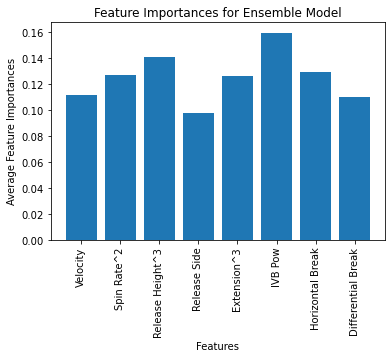

In [16]:
features_list = ['Velocity', 'Spin Rate^2', 'Release Height^3', 'Release Side', 'Extension^3', 'IVB Pow', 'Horizontal Break', 'Differential Break']

plt.bar(features_list, average_feature_importances)
plt.xlabel('Features')
plt.ylabel('Average Feature Importances')
plt.title('Feature Importances for Ensemble Model')
plt.xticks(rotation=90)
plt.show()

In [17]:
X = dfcb[['Velocity', 'Spin Rate^2', 'Release Height^3', 'Release Side', 'Extension^3', 'IVB Pow', 'Horizontal Break', 'Differential Break']]
# Original: X = dfbr[['Velocity', 'Spin Rate', 'Induced Vertical Break', 'Horizontal Break', 'Differential Break', 'Release Height', 'Release Side', 'Extension', 'Hgt x IVB', 'Velo^3 + Velo^2', 'IndVert^2', 'DiffBreak^2']]
y = dfcb['Whiff']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Make predictions on the training set using all the models
linear_pred_train = linear_model.predict(X_train_scaled)
rf_pred_train = random_forest_model.predict(X_train_scaled)
xgb_pred_train = xgb_model.predict(X_train_scaled)
svr_pred_train = svr_model.predict(X_train_scaled)
keras_nn_pred_train = nn_model.predict(X_train_scaled).flatten()

67/67 [==============================] - 0s 2ms/step


In [19]:
# Make predictions on the test set using all the models
linear_pred_test = linear_model.predict(X_test_scaled)
rf_pred_test = random_forest_model.predict(X_test_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)
svr_pred_test = svr_model.predict(X_test_scaled)
keras_nn_pred_test = nn_model.predict(X_test_scaled).flatten()

17/17 [==============================] - 0s 2ms/step


In [20]:
# Combine predictions using averaging for the training set
ensemble_predictions_train = (linear_pred_train + rf_pred_train + xgb_pred_train + svr_pred_train + keras_nn_pred_train) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the training set
ensemble_df_train = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_train}, index=X_train.index)

In [21]:
# Combine predictions using averaging for the test set
ensemble_predictions_test = (linear_pred_test + rf_pred_test + xgb_pred_test + svr_pred_test + keras_nn_pred_test) / 5.0

# Create a new DataFrame with the predictions and the corresponding index for the test set
ensemble_df_test = pd.DataFrame({'expected_whiff_rates': ensemble_predictions_test}, index=X_test.index)

In [22]:
# Concatenate the training and test set DataFrames
ensemble_df = pd.concat([ensemble_df_train, ensemble_df_test])

In [23]:
# Calculate the 'Stuff+' values
dfcb['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100

<ipython-input-23-aa333ceeeb05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcb['Stuff+'] = (ensemble_df['expected_whiff_rates'] / ensemble_df['expected_whiff_rates'].mean()) * 100


In [24]:
dfcb = dfcb.round(2)

In [25]:
dfcb['Stuff+'].describe()

count    2677.000000
mean      100.000134
std        34.455276
min        11.360000
25%        71.600000
50%        97.660000
75%       124.560000
max       207.360000
Name: Stuff+, dtype: float64

In [26]:
dfcb.head(30)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Hit Type,KorBB,Differential Break,Whiff,Swing,IVB Pow,Release Height^3,Extension^3,Spin Rate^2,Stuff+
5,Javyn Pimental,Curveball,BallCalled,BRE_WHI,Josh Kuroda-Grauer,BOU_BRA,Left,77.21,1887.94,5.15,...,Undefined,Undefined,23.44,0,0,-268.55,136.93,131.31,3564332.98,64.16
6,Javyn Pimental,Curveball,BallCalled,BRE_WHI,Josh Kuroda-Grauer,BOU_BRA,Left,77.55,1885.76,5.12,...,Undefined,Undefined,21.50,0,0,-810.51,134.11,143.52,3556082.05,93.41
12,Javyn Pimental,Curveball,StrikeSwinging,BRE_WHI,Garett Michel,BOU_BRA,Left,77.97,2088.10,5.22,...,Undefined,Strikeout,19.68,1,1,-351.17,141.97,145.44,4360166.86,103.63
16,Javyn Pimental,Curveball,StrikeCalled,BRE_WHI,Joey Loynd,BOU_BRA,Left,77.81,1953.38,5.22,...,Undefined,Undefined,16.52,0,0,-154.11,142.41,130.26,3815703.92,79.03
20,Javyn Pimental,Curveball,InPlay,BRE_WHI,Joey Loynd,BOU_BRA,Left,76.81,1944.47,5.17,...,Popup,Undefined,22.26,0,1,-1741.41,138.48,129.45,3780965.10,64.74
49,Javyn Pimental,Curveball,FoulBall,BRE_WHI,Jackson Castillo,BOU_BRA,Left,77.30,1974.83,5.22,...,Undefined,Undefined,17.61,0,0,-147.68,142.05,117.19,3899937.40,64.66
51,Javyn Pimental,Curveball,StrikeCalled,BRE_WHI,Kodey Shojinaga,BOU_BRA,Left,75.76,2125.03,5.14,...,Undefined,Undefined,20.07,0,0,-87.18,135.69,138.46,4515736.03,72.81
60,Ryan Fischer,Curveball,BallCalled,BOU_BRA,Dylan Leach,BRE_WHI,Right,78.97,2247.09,5.18,...,Undefined,Undefined,7.02,0,0,99.08,138.86,185.28,5049396.84,121.11
78,Javyn Pimental,Curveball,BallCalled,BRE_WHI,Brett Callahan,BOU_BRA,Left,78.02,2051.05,5.19,...,Undefined,Undefined,11.63,0,0,-35.90,140.16,139.54,4206795.20,95.13
82,Javyn Pimental,Curveball,BallCalled,BRE_WHI,Josh Kuroda-Grauer,BOU_BRA,Left,78.17,2036.18,5.19,...,Undefined,Undefined,22.84,0,0,-367.72,140.02,131.66,4146022.42,94.72


In [27]:
# Sort the DataFrame by 'Stuff+' values in descending order
dfcb_sorted = dfcb.sort_values(by='Stuff+', ascending=False)

# Reset the index of the sorted DataFrame
dfcb_sorted.reset_index(drop=True, inplace=True)

dfcb_sorted.head(20)

,Pitcher,Pitch Type,Pitch Result,Pitcher Team,Batter,Batter Team,P Side,Velocity,Spin Rate,Release Height,...,Hit Type,KorBB,Differential Break,Whiff,Swing,IVB Pow,Release Height^3,Extension^3,Spin Rate^2,Stuff+
0,Sean Hard,Curveball,BallCalled,HAR_MAR,Zack Stewart,WAR_GAT,Right,76.51,2775.62,6.14,...,Undefined,Undefined,8.86,0,0,-9060.31,231.17,225.83,7704040.68,207.36
1,Carson Benge,Curveball,BallCalled,CHA_ANG,Mason Guerra,HAR_MAR,Right,78.99,2691.06,5.76,...,Undefined,Undefined,8.86,0,0,-6661.63,191.41,223.91,7241791.59,198.59
2,Sean Hard,Curveball,BallCalled,HAR_MAR,Nick McLain,WAR_GAT,Right,83.86,2341.13,6.08,...,Undefined,Undefined,9.65,0,0,243.10,225.30,277.07,5480876.68,195.39
3,Carson Benge,Curveball,BallCalled,CHA_ANG,Ali Camarillo,HAR_MAR,Right,78.00,2800.76,5.69,...,Undefined,Undefined,10.60,0,0,-8571.08,183.86,188.68,7844280.13,194.68
4,Trey Gibson,Curveball,StrikeCalled,CHA_ANG,Andrew Sundean,HYA_HAR,Right,77.14,2281.27,6.09,...,Undefined,Undefined,14.77,0,0,-10168.62,226.34,240.04,5204211.87,193.02
5,Trey Gibson,Curveball,BallinDirt,CHA_ANG,Brody Donay,HYA_HAR,Right,76.60,2346.25,6.03,...,Undefined,Undefined,10.30,0,0,-9661.22,218.86,253.71,5504905.54,192.89
6,Ben Peterson,Curveball,BallinDirt,CHA_ANG,Sebastian Murillo,WAR_GAT,Right,80.43,2597.81,5.95,...,Undefined,Undefined,13.75,0,0,-14559.79,210.76,118.88,6748629.37,192.63
7,Sean Hard,Curveball,BallinDirt,HAR_MAR,Eddie Micheletti,ORL_FIR,Right,75.20,2658.53,6.12,...,Undefined,Undefined,8.52,0,0,-7334.71,229.00,221.60,7067775.43,190.21
8,Tanner Witt,Curveball,BallCalled,CHA_ANG,Jack Goodman,HAR_MAR,Right,74.73,2717.68,6.55,...,Undefined,Undefined,11.42,0,0,-7145.04,280.91,242.94,7385758.45,189.13
9,Trey Gibson,Curveball,BallinDirt,CHA_ANG,Zach Yorke,HYA_HAR,Right,76.03,2207.41,6.04,...,Undefined,Undefined,10.28,0,0,-11785.03,220.13,210.63,4872659.81,187.91


In [28]:
average_cb_Stuff = dfcb[dfcb['Pitch Type'] == 'Curveball'].groupby('Pitcher')['Stuff+'].mean()
average_cb_Stuff = average_cb_Stuff.round(2)

# Sort the Series in descending order based on the average Stuff+ values
average_cb_Stuff_sorted = average_cb_Stuff.sort_values(ascending=False)

average_cb_Stuff_sorted

Pitcher
Carson Benge     181.03
Hunter Hodges    169.48
Sean Hard        158.38
Doug Kirkland    157.77
Trey Gibson      155.03
                  ...  
Ben Kovel         38.62
Kros Sivley       32.18
Hector Garcia     30.23
John Modugno      27.40
Shane Cronin      26.71
Name: Stuff+, Length: 192, dtype: float64